# BrushInsight: AI-Powered Art Curator - Training Notebook

Bu notebook, **Transfer Learning (ResNet50)** kullanarak dünyanın en etkili 10 ressamının eserlerini sınıflandırmak için hazırlanmıştır.

**Adımlar:**
1. Kaggle API ile veri setinin çekilmesi.
2. En çok eseri olan 10 sanatçının filtrelenmesi.
3. ResNet50 modelinin `best-artworks-of-all-time` verisi ile eğitilmesi.
4. Eğitilen modelin `artist_model.h5` olarak kaydedilmesi.

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import zipfile
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import files

print("--- KURULUM VE DONANIM RAPORU ---")
print(f"TensorFlow Versiyonu: {tf.__version__}")
gpu_status = tf.test.gpu_device_name()
print(f"GPU Durumu: {gpu_status if gpu_status else 'CPU (UYARI: Eğitim yavaş sürebilir!)'}")

--- KURULUM VE DONANIM RAPORU ---
TensorFlow Versiyonu: 2.19.0
GPU Durumu: /device:GPU:0


## 1. Veri Seti Hazırlığı (Kaggle)

Lütfen bilgisayarınızdaki `kaggle.json` dosyasını aşağıya yükleyin.
(Kaggle > Settings > Create New Token)

In [59]:
# kaggle.json dosyasını yükleyin
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Veriyi indir
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

import zipfile
import os
import shutil

zip_file = "best-artworks-of-all-time.zip"

print(f"--- VERİ AYIKLAMA BAŞLATILDI ---")

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_contents = zip_ref.namelist()

    # Senaryo 1: İç içe geçmiş 'resized.zip' varsa
    if "resized.zip" in zip_contents:
        print("'resized.zip' bulundu, iç içe yapı çözülüyor...")
        zip_ref.extract("resized.zip")
        zip_ref.extract("artists.csv")
        with zipfile.ZipFile("resized.zip", 'r') as resized_ref:
            resized_ref.extractall("dataset")

    # Senaryo 2: Veriler doğrudan ana zip içindeyse
    else:
        print("'resized.zip' bulunamadı, ana paket doğrudan 'dataset' klasörüne açılıyor...")
        zip_ref.extractall("dataset")
        # artists.csv'yi ana dizine taşı (Kodun geri kalanı burada bekliyor)
        if os.path.exists("dataset/artists.csv"):
            shutil.copy("dataset/artists.csv", "artists.csv")

# Dinamik Yol Belirleme (Hücre 3'ün hata almaması için kritik)
possible_paths = [
    'dataset/resized/resized',
    'dataset/resized',
    'dataset/images/images',
    'dataset/images',
    'dataset'
]

base_dir = None
for path in possible_paths:
    if os.path.exists(path) and any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))):
        base_dir = path
        break

print("\n--- VERİ HAZIRLIK RAPORU ---")
if base_dir:
    print(f"BAŞARILI: Resimler şurada bulundu -> {base_dir}")
    print(f"Diskteki Görüntü Sayısı: {len([f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))])}")
else:
    print("HATA: Resim dosyaları hiçbir klasörde bulunamadı!")

# base_dir değişkenini global yapıyoruz ki sonraki hücreler kullansın
os.environ['BASE_DIR'] = base_dir

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
License(s): CC-BY-NC-SA-4.0
best-artworks-of-all-time.zip: Skipping, found more recently modified local copy (use --force to force download)
--- VERİ AYIKLAMA BAŞLATILDI ---
'resized.zip' bulunamadı, ana paket doğrudan 'dataset' klasörüne açılıyor...

--- VERİ HAZIRLIK RAPORU ---
BAŞARILI: Resimler şurada bulundu -> dataset/resized/resized
Diskteki Görüntü Sayısı: 8683


## 2. Veri İşleme ve Filtreleme
En çok eseri olan ilk 10 sanatçıyı seçeceğiz.


--- VERİ İŞLEME VE SINIF DAĞILIMI ---
Toplam Eşleşen Görüntü: 4388
Sınıf Dağılımı:
class
Vincent_van_Gogh         877
Edgar_Degas              702
Albrecht_Durer           656
Pablo_Picasso            439
Pierre-Auguste_Renoir    336
Paul_Gauguin             311
Francisco_Goya           291
Rembrandt                262
Alfred_Sisley            259
Titian                   255
Name: count, dtype: int64


/tmp/ipython-input-1382656042.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['class'], palette='viridis')


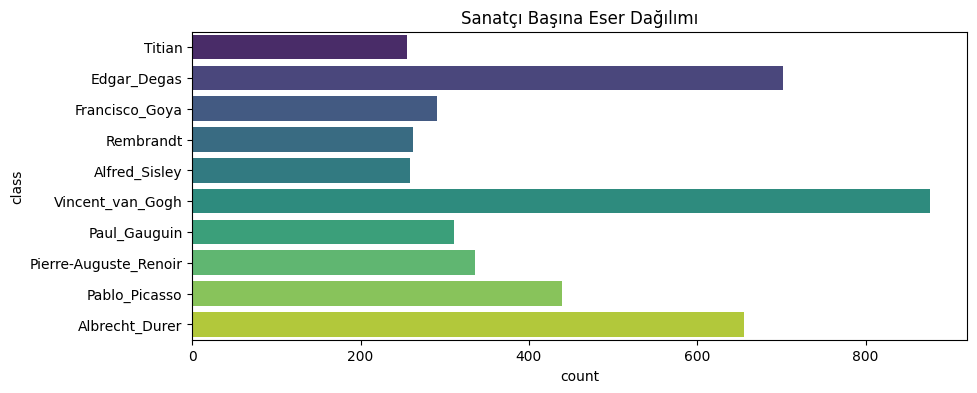

In [60]:
artists = pd.read_csv('artists.csv')
top_10_names = artists.sort_values(by='paintings', ascending=False).head(10)['name'].tolist()

file_paths, labels = [], []
all_files = os.listdir(base_dir)

for img_file in all_files:
    if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')): continue
    for artist in top_10_names:
        prefix = artist.replace(' ', '_')[:10]
        if img_file.startswith(prefix):
            file_paths.append(os.path.join(base_dir, img_file))
            labels.append(artist.replace(' ', '_').replace('ü', 'u'))
            break

df = pd.DataFrame({'filename': file_paths, 'class': labels})

print("\n--- VERİ İŞLEME VE SINIF DAĞILIMI ---")
print(f"Toplam Eşleşen Görüntü: {len(df)}")
print(f"Sınıf Dağılımı:\n{df['class'].value_counts()}")

plt.figure(figsize=(10,4))
sns.countplot(y=df['class'], palette='viridis')
plt.title("Sanatçı Başına Eser Dağılımı")
plt.show()

## 2.1 Hücre 2.1: Veri Analizi ve Sınıf Dağılımı (YENİ)

/tmp/ipython-input-873074540.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='class', order=df['class'].value_counts().index, palette='viridis')


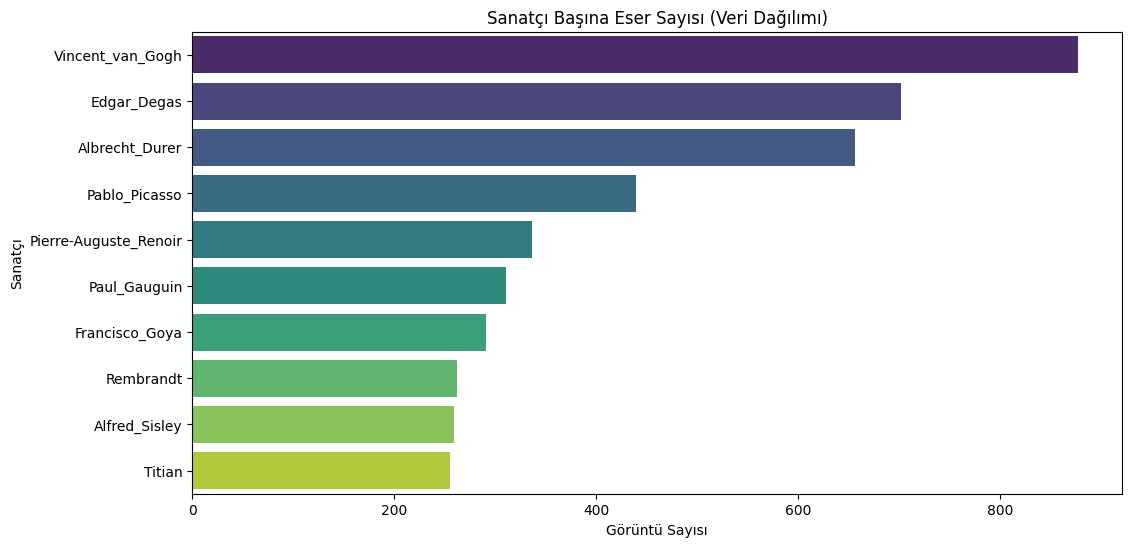

Toplam Görüntü: 4388
Ortalama Eser Sayısı: 438.80


In [61]:
# Sınıf dağılımını görselleştirme
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='class', order=df['class'].value_counts().index, palette='viridis')
plt.title('Sanatçı Başına Eser Sayısı (Veri Dağılımı)')
plt.xlabel('Görüntü Sayısı')
plt.ylabel('Sanatçı')
plt.show()

# İstatistiksel özet
print(f"Toplam Görüntü: {len(df)}")
print(f"Ortalama Eser Sayısı: {df['class'].value_counts().mean():.2f}")

## 3. Data Generators (Veri Yükleyicileri)

In [62]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# %10 Test, %90 Train+Val (Stratified)
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=42)
target_classes = sorted(df['class'].unique().tolist())

# OVERFITTING ENGELLEME: Data Augmentation (Not Sayfa 65: Mirroring, Cropping vb.)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', classes=target_classes, subset='training'
)

val_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', classes=target_classes, subset='validation'
)

test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_dataframe(
    test_df, x_col='filename', y_col='class', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', classes=target_classes, shuffle=False
)

print("\n--- GENERATOR ÖZETİ ---")
print(f"Eğitim Örnek Sayısı: {train_gen.samples}")
print(f"Doğrulama Örnek Sayısı: {val_gen.samples}")
print(f"Test Örnek Sayısı: {test_gen.samples}")
with open('class_indices.json', 'w') as f: json.dump(train_gen.class_indices, f)

Found 3160 validated image filenames belonging to 10 classes.
Found 789 validated image filenames belonging to 10 classes.
Found 439 validated image filenames belonging to 10 classes.

--- GENERATOR ÖZETİ ---
Eğitim Örnek Sayısı: 3160
Doğrulama Örnek Sayısı: 789
Test Örnek Sayısı: 439


## 4. Model Kurulumu (ResNet50)

In [67]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
# OVERFITTING ENGELLEME: L2 Regularization ve Daha Sade Katman (512 nöron)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- MODEL MİMARİ RAPORU ---")
print(f"Toplam Katman Sayısı: {len(model.layers)}")
print(f"Eğitilebilir Parametre Sayısı: {model.count_params()}")


--- MODEL MİMARİ RAPORU ---
Toplam Katman Sayısı: 179
Eğitilebilir Parametre Sayısı: 24641930


# 5. Aşama -1 Eğitim

In [68]:
checkpoint = ModelCheckpoint('artist_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Aşama 1: Isınma Eğitimi Başlıyor...\n")
history_phase1 = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[checkpoint, early_stop])

print("\n--- AŞAMA 1 SONUÇ ÖZETİ ---")
print(f"Final Train Accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")

Aşama 1: Isınma Eğitimi Başlıyor...

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.4670 - loss: 2.6743
Epoch 1: val_accuracy improved from -inf to 0.73257, saving model to artist_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 84s 733ms/step - accuracy: 0.4681 - loss: 2.6687 - val_accuracy: 0.7326 - val_loss: 1.4877
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.7254 - loss: 1.4850
Epoch 2: val_accuracy improved from 0.73257 to 0.77820, saving model to artist_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 62s 627ms/step - accuracy: 0.7254 - loss: 1.4847 - val_accuracy: 0.7782 - val_loss: 1.2630
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7474 - loss: 1.3061
Epoch 3: val_accuracy did not improve from 0.77820
99/99 ━━━━━━━━━━━━━━━━━━━━ 60s 606ms/step - accuracy: 0.7475 - loss: 1.3057 - val_accuracy: 0.7706 - val_loss: 1.1453
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7908 - loss: 1.1432
Epoch 4: val_accuracy did not impro

# Hücre 6: Aşama 2 Fine-Tuning (Titian & Goya Kurtarma)

In [69]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
cw_dict = dict(enumerate(weights))

base_model.trainable = True
for layer in base_model.layers[:-20]: layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print("Aşama 2: Fine-Tuning ve Sınıf Ağırlıklandırma Başlıyor...\n")
history_phase2 = model.fit(train_gen, epochs=5, validation_data=val_gen, class_weight=cw_dict, callbacks=[checkpoint, early_stop])

print("\n--- AŞAMA 2 SONUÇ ÖZETİ ---")
print(f"Final Train Accuracy: {history_phase2.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history_phase2.history['val_accuracy'][-1]:.4f}")

Aşama 2: Fine-Tuning ve Sınıf Ağırlıklandırma Başlıyor...

Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8571 - loss: 0.7917
Epoch 1: val_accuracy improved from 0.81749 to 0.82003, saving model to artist_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 90s 744ms/step - accuracy: 0.8571 - loss: 0.7915 - val_accuracy: 0.8200 - val_loss: 0.8407
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8698 - loss: 0.7179
Epoch 2: val_accuracy improved from 0.82003 to 0.83777, saving model to artist_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 637ms/step - accuracy: 0.8698 - loss: 0.7178 - val_accuracy: 0.8378 - val_loss: 0.8109
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8776 - loss: 0.6469
Epoch 3: val_accuracy improved from 0.83777 to 0.83904, saving model to artist_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 65s 660ms/step - accuracy: 0.8777 - loss: 0.6470 - val_accuracy: 0.8390 - val_loss: 0.8045
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accura

## 7. Sonuçlar ve Kaydetme


--- BAĞIMSIZ NİHAİ TEST RAPORU ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8671 - loss: 0.7408
NET TEST SKORU: %86.56
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step

SINIFLANDIRMA DETAYLARI:
                       precision    recall  f1-score   support

       Albrecht_Durer       0.96      0.98      0.97        66
        Alfred_Sisley       0.85      0.85      0.85        26
          Edgar_Degas       0.92      0.83      0.87        70
       Francisco_Goya       0.79      0.66      0.72        29
        Pablo_Picasso       0.82      0.82      0.82        44
         Paul_Gauguin       0.82      0.87      0.84        31
Pierre-Auguste_Renoir       0.91      0.88      0.90        34
            Rembrandt       0.71      0.92      0.80        26
               Titian       0.84      0.84      0.84        25
     Vincent_van_Gogh       0.88      0.89      0.88        88

             accuracy                           0.87       439
            macro avg       0.85      0.85      0.85       439
         weig

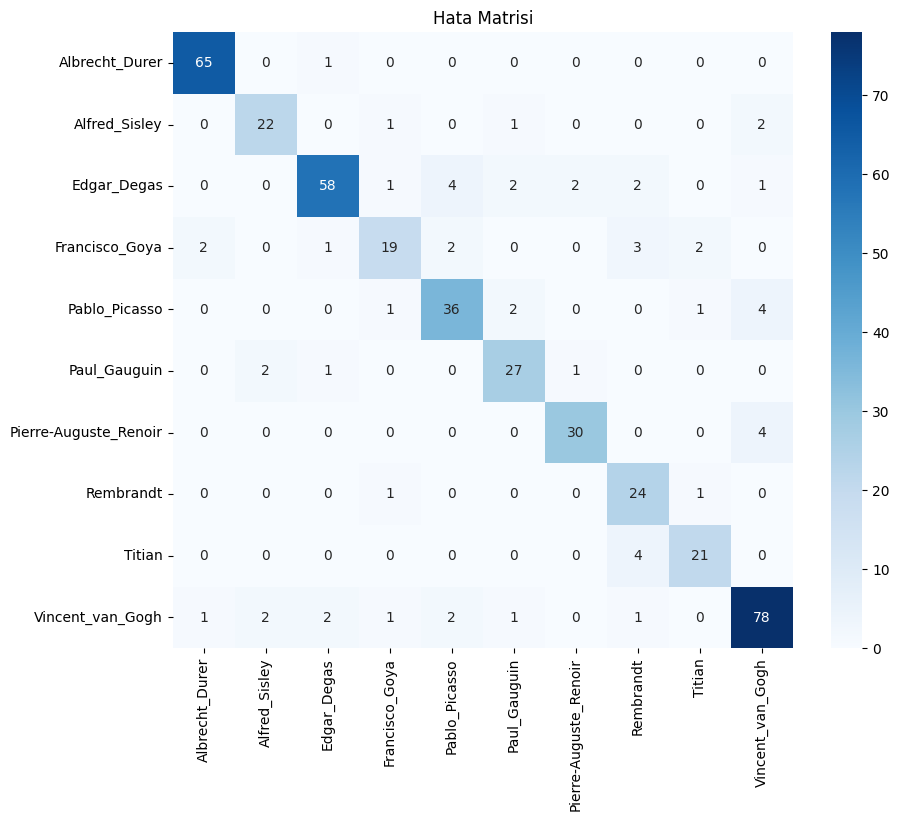

In [70]:
print("\n--- BAĞIMSIZ NİHAİ TEST RAPORU ---")
results = model.evaluate(test_gen)
print(f"NET TEST SKORU: %{results[1]*100:.2f}")

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

print("\nSINIFLANDIRMA DETAYLARI:")
print(classification_report(y_true, y_pred, target_names=target_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
plt.title("Hata Matrisi")
plt.show()

# Hücre 8 GRADCAM

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_895']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


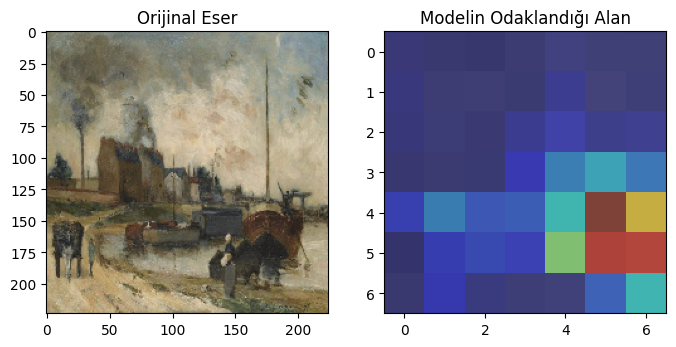

In [71]:
def plot_gradcam(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_arr = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img, axis=0))

    grad_model = Model([model.inputs], [model.get_layer("conv5_block3_out").output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_arr)
        class_channel = preds[:, np.argmax(preds[0])]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)).numpy()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Orijinal Eser")
    plt.subplot(1,2,2); plt.imshow(img); plt.imshow(heatmap, cmap='jet', alpha=0.5); plt.title("Modelin Odaklandığı Alan")
    plt.show()

# Rastgele bir test örneği üzerinde göster
plot_gradcam(test_df.iloc[np.random.randint(0, len(test_df))]['filename'], model)



In [72]:
files.download('artist_model.keras')
files.download('class_indices.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>